In [16]:
import os
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import yfinance as yf   
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro 
import math
from scipy import stats
from scipy.stats import kstest
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


           AAPL      MSFT      AMZN     GOOGL      TSLA      NVDA       JPM  \
AAPL   1.000000  0.899265  0.241193  0.840267  0.734206  0.717460  0.712117   
MSFT   0.899265  1.000000  0.391694  0.895522  0.568939  0.910010  0.845404   
AMZN   0.241193  0.391694  1.000000  0.515083  0.425045  0.320885  0.393624   
GOOGL  0.840267  0.895522  0.515083  1.000000  0.756639  0.698410  0.840362   
TSLA   0.734206  0.568939  0.425045  0.756639  1.000000  0.268103  0.489052   
NVDA   0.717460  0.910010  0.320885  0.698410  0.268103  1.000000  0.780713   
JPM    0.712117  0.845404  0.393624  0.840362  0.489052  0.780713  1.000000   
JNJ    0.737702  0.577173 -0.000305  0.657269  0.665208  0.349370  0.541937   
BRK-B  0.891073  0.904075  0.120849  0.810853  0.521460  0.834319  0.827581   
V      0.745471  0.868439  0.386782  0.741713  0.319946  0.861801  0.868827   
PG     0.906770  0.859726  0.174387  0.772538  0.586751  0.741636  0.697224   
UNH    0.876563  0.742659 -0.091573  0.690843  0.618

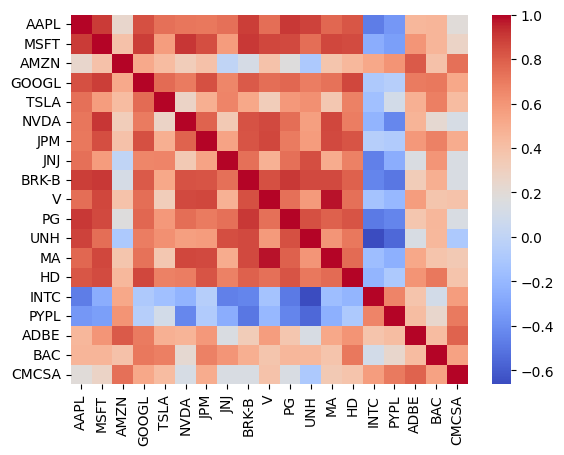

In [17]:


fortune500_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'BRK-B', 'V', 'PG', 'UNH', 'MA', 'HD', 'INTC', 'PYPL', 'ADBE', 'BAC', 'CMCSA']
fortune500_dataset = {}

for ticker in fortune500_tickers:
    fortune500csv = f"{ticker}.csv"
    if os.path.exists(fortune500csv):
        
        fortune500_dataset[ticker] = pd.read_csv(fortune500csv)
    else:
        
        try:
            data = yf.download(ticker, start='2020-01-01', end='2024-04-22')
            fortune500_dataset[ticker] = data
            data.to_csv(fortune500csv)
        except:
            print(f"Failed to fetch data for {ticker}")

for ticker in fortune500_dataset:
    fortune500_dataset[ticker]['Date'] = pd.to_datetime(fortune500_dataset[ticker]['Date'])
    fortune500_dataset[ticker].set_index('Date', inplace=True)




adj_close_df = pd.DataFrame()

for ticker in fortune500_dataset:
    adj_close_df[ticker] = fortune500_dataset[ticker]['Adj Close']


correlation_matrix = adj_close_df.corr()

print(correlation_matrix)


sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()







 

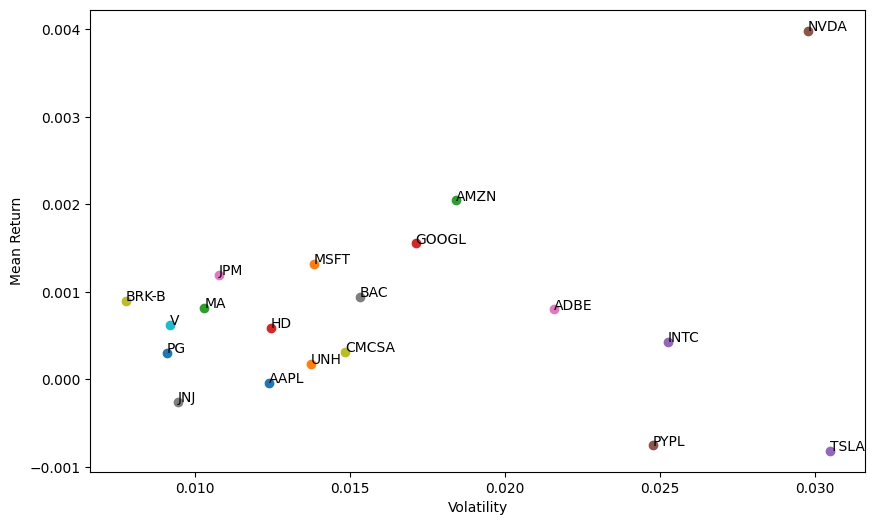

In [18]:
for ticker in fortune500_dataset:
    fortune500_dataset[ticker]["lnret"] = np.log(fortune500_dataset[ticker]['Adj Close'] / fortune500_dataset[ticker]['Adj Close'].shift(1)).bfill() 
    fortune500_dataset[ticker]["meanRet"] = fortune500_dataset[ticker]["lnret"].rolling(window=252).mean()
    fortune500_dataset[ticker]["stdRet"] = fortune500_dataset[ticker]["lnret"].rolling(window=252).std()



def plotMeanReturnVSVolatility(dataset):
    plt.figure(figsize=(10, 6))

    for ticker, data in dataset.items():
        mean_return = data['meanRet'].iloc[-1]  # get the last value
        volatility = data['stdRet'].iloc[-1]  # get the last value
        plt.scatter(volatility, mean_return)
        plt.annotate(ticker, (volatility, mean_return))

    plt.xlabel('Volatility')
    plt.ylabel('Mean Return')
    plt.show()

# Usage
plotMeanReturnVSVolatility(fortune500_dataset)   











In [19]:
def getStats(Tick, Column, dataset):
    for x in Tick:
        if x in dataset:
            skew = dataset[x][Column].skew()
            kurt = dataset[x][Column].kurt()
            mean = dataset[x][Column].mean()
            median = dataset[x][Column].median()
            var = dataset[x][Column].var()
            std = dataset[x][Column].std()
            print(f"Mean for {x} {Column}: {mean}")
            print(f"Median for {x} {Column}: {median}")
            print(f"Variance for {x} {Column}: {var}")
            print(f"Standard Deviation for {x} {Column}: {std}")
            print(f"Skewness for {x} {Column}: {skew}")
            print(f"Kurtosis for {x} {Column}: {kurt}")
        else:
            print(f"No data for {x}")   


getStats(['AAPL'], 'lnret', fortune500_dataset)

Mean for AAPL lnret: 0.0007439027573079487
Median for AAPL lnret: 0.0005968681644121864
Variance for AAPL lnret: 0.0004284808093088527
Standard Deviation for AAPL lnret: 0.020699778001438872
Skewness for AAPL lnret: -0.11936675813800535
Kurtosis for AAPL lnret: 5.123839424809722


In [20]:
def getADF(Tick, Column, dataset):
    for x in Tick:
        if x in dataset: 
            result = adfuller(dataset[x][Column])
            print(f"ADF Statistic for {x} {Column}: {result[0]}")
            print(f"p-value for {x} {Column}: {result[1]}")
            if result[1] < 0.05:
                print('\033[92m'+f"{x} {Column} is stationary")
            else: 
                print('\033[91m'+f"{x} {Column} is not stationary")   
        else: 
            print(f"No data for {x}")


getADF(['AAPL'], "Adj Close", fortune500_dataset)

                       
    
    

ADF Statistic for AAPL Adj Close: -1.9815104689574694
p-value for AAPL Adj Close: 0.2947384902230158
AAPL Adj Close is not stationary


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


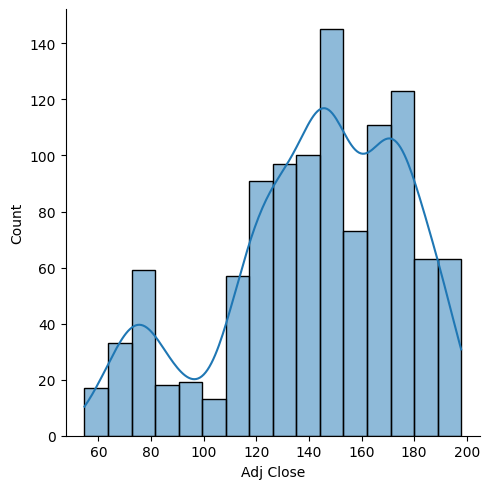

In [21]:
def plotDistr(Tick, Column, dataset):
        for x in Tick:
            if x in dataset:
                sns.displot(dataset[x][Column], kde=True)
                plt.show()

plotDistr(['AAPL'], 'Adj Close', fortune500_dataset)   
        

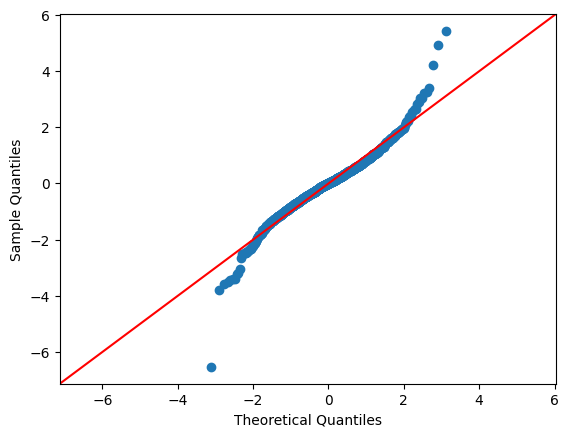

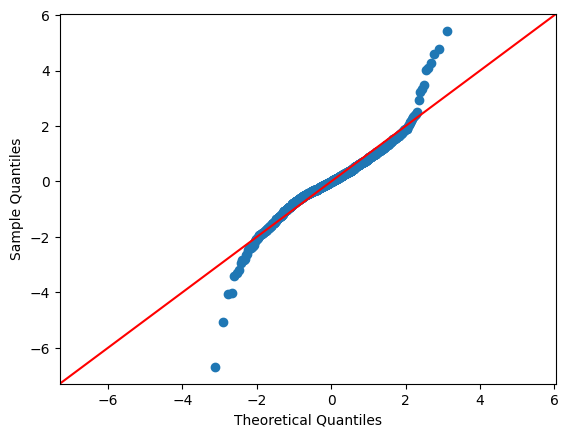

In [22]:
def getQQPlotted(Tick, Column, dataset):
    for ticker in Tick:
        if ticker in dataset:
            fig = sm.qqplot(dataset[ticker][Column], line='45', fit=True)
            plt.show()

getQQPlotted(['AMZN', "AAPL"], 'lnret', fortune500_dataset)

In [23]:
def getSWTested(tickers, column, dataset):
    for ticker in tickers:
        if ticker in dataset:
            result = stats.shapiro(dataset[ticker][column])
            print(f"Shapiro-Wilk test for {ticker} {column}: {result}")
            if result[1] > 0.05:
                print('\033[92m'+"Data is normally distributed")
            else:
                print('\033[91m'+"Data is not normally distributed according to Shapiro-Wilk test")
        else:
            print(f"Ticker {ticker} not found in the dataset")


getSWTested(["AMZN"],["lnret"], fortune500_dataset)


Shapiro-Wilk test for AMZN ['lnret']: ShapiroResult(statistic=0.9604338450849689, pvalue=1.5341909040596385e-16)
Data is not normally distributed according to Shapiro-Wilk test


In [24]:
def getKSTested(tickers, column, dataset):
    for ticker in tickers:
        if ticker in dataset:
            for col in column:
                result = stats.kstest(dataset[ticker][col], 'norm')
                print(f"Kolmogorov-Smirnov test for {ticker} {col}: {result}")
                if result[1] > 0.05:
                    print('\033[92m'+"Data is normally distributed")
                else:
                    print('\033[91m'+"Data is not normally distributed according to Kolmogorov-Smirnov test")
        else:
            print(f"Ticker {ticker} not found in the dataset")  

getKSTested(["AAPL"], ["lnret"], fortune500_dataset)
 

Kolmogorov-Smirnov test for AAPL lnret: KstestResult(statistic=0.46984238129808376, pvalue=1.3703914779301931e-219, statistic_location=0.05245136011650165, statistic_sign=1)
Data is not normally distributed according to Kolmogorov-Smirnov test


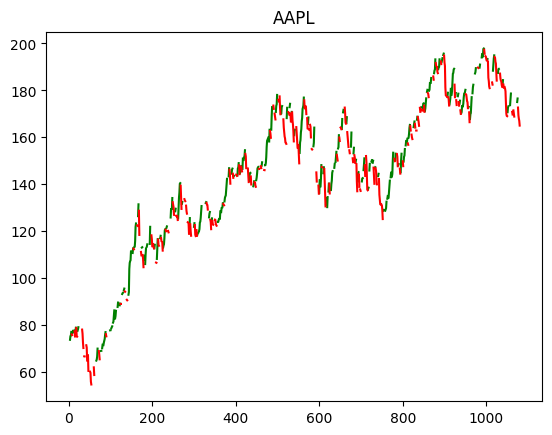

In [25]:
def simpleMomentum(tickers, column, dataset):
    for ticker in tickers:
        if ticker in dataset:
            upward = []
            downward = []  
            for row in range(1, len(dataset[ticker])):
                if dataset[ticker][column].iloc[row] > dataset[ticker][column].iloc[row - 1]:
                    upward.append(dataset[ticker][column].iloc[row])
                    downward.append(None)
                else:
                    upward.append(None)
                    downward.append(dataset[ticker][column].iloc[row])
            plt.plot(upward, 'g', downward, 'r')
            plt.title(ticker)
            plt.show() 
            

simpleMomentum(["AAPL"], "Adj Close", fortune500_dataset)



In [26]:
def buyandhold(dataset, column, tickers, initial_value):
    final_values = {}
    for ticker in tickers:
        if ticker in dataset:
            final_value = initial_value
            for x in dataset[ticker][column]:
                final_value *= np.exp(x)
            final_values[ticker] = final_value
    return final_values

buyandhold(fortune500_dataset, "lnret", fortune500_tickers, 1000000)


{'AAPL': 2236479.0653764834,
 'MSFT': 2551236.326172615,
 'AMZN': 1817800.431625387,
 'GOOGL': 2239879.343165654,
 'TSLA': 5278467.915714589,
 'NVDA': 12550852.648510316,
 'JPM': 1484196.5274520356,
 'JNJ': 1123739.6244214436,
 'BRK-B': 1756470.2803158087,
 'V': 1442372.689560009,
 'PG': 1423022.3286797674,
 'UNH': 1804201.6476782467,
 'MA': 1524222.4508601786,
 'HD': 1685474.3240862724,
 'INTC': 623019.6119374334,
 'PYPL': 552509.1802734423,
 'ADBE': 1379591.9457557225,
 'BAC': 1129628.4742582531,
 'CMCSA': 981322.6838207431}

In [27]:
def MA(dataset, column, tickers, window):
    for ticker in tickers:
        if ticker in dataset:
            dataset[ticker]["MA"] = dataset[ticker][column].rolling(window=window).mean().bfill()   
            return dataset[ticker]["MA"]
        
    
MA(fortune500_dataset, "Adj Close", fortune500_tickers, 20)


        
 

Date
2020-01-02     75.902135
2020-01-03     75.902135
2020-01-06     75.902135
2020-01-07     75.902135
2020-01-08     75.902135
                 ...    
2024-04-15    171.728500
2024-04-16    171.511500
2024-04-17    171.107500
2024-04-18    170.525999
2024-04-19    170.207500
Name: MA, Length: 1082, dtype: float64

In [28]:
def MSTD(dataset, column, tickers, window):
    for ticker in tickers:
        if ticker in dataset:
            dataset[ticker]["MSTD"] = dataset[ticker][column].rolling(window=window).std().bfill()   
            return dataset[ticker]["MSTD"]

MSTD(fortune500_dataset, "Adj Close", fortune500_tickers, 20)   

Date
2020-01-02    2.034912
2020-01-03    2.034912
2020-01-06    2.034912
2020-01-07    2.034912
2020-01-08    2.034912
                ...   
2024-04-15    3.019809
2024-04-16    3.025099
2024-04-17    2.920601
2024-04-18    2.456556
2024-04-19    2.738172
Name: MSTD, Length: 1082, dtype: float64

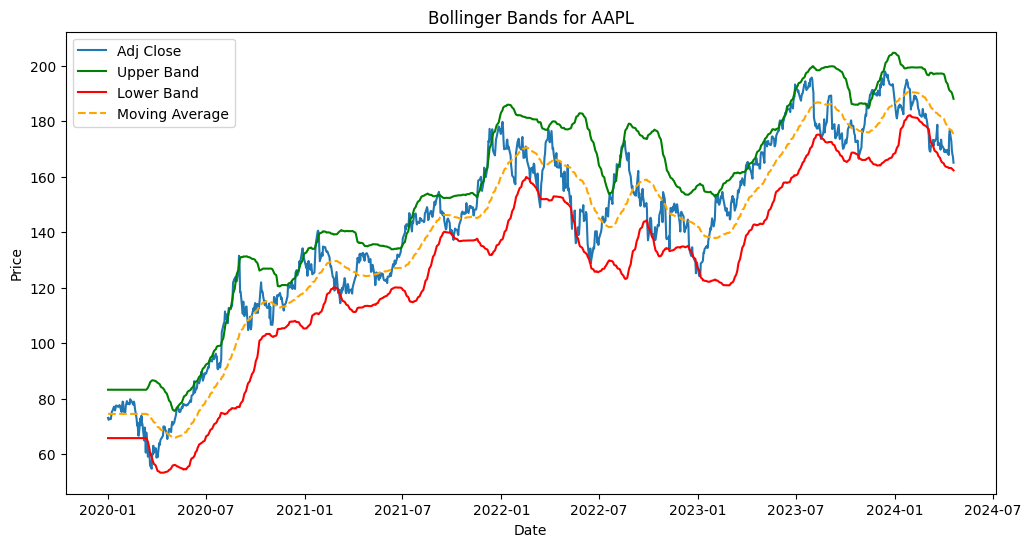

In [29]:
def BollingerB(dataset, tickers, column, ma, mstd, nstd):
    for ticker in tickers:
        if ticker in dataset:
            dataset[ticker]["MA"] = dataset[ticker][column].rolling(window=ma).mean().bfill()
            dataset[ticker]["MSTD"] = dataset[ticker][column].rolling(window=mstd).std().bfill()
            dataset[ticker]["Upper Band"] = dataset[ticker]["MA"] + nstd*dataset[ticker]["MSTD"]
            dataset[ticker]["Lower Band"] = dataset[ticker]["MA"] - nstd*dataset[ticker]["MSTD"]

            plt.figure(figsize=(12,6))
            plt.plot(dataset[ticker]['Adj Close'], label='Adj Close')
            plt.plot(dataset[ticker]['Upper Band'], label='Upper Band', color='green')
            plt.plot(dataset[ticker]['Lower Band'], label='Lower Band', color='red')
            plt.plot(dataset[ticker]['MA'], label='Moving Average', color='orange', linestyle='--') 
            plt.title(f'Bollinger Bands for {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.show()
            
        


BollingerB(fortune500_dataset, ["AAPL"], "Adj Close", 50, 50, 2) 
        



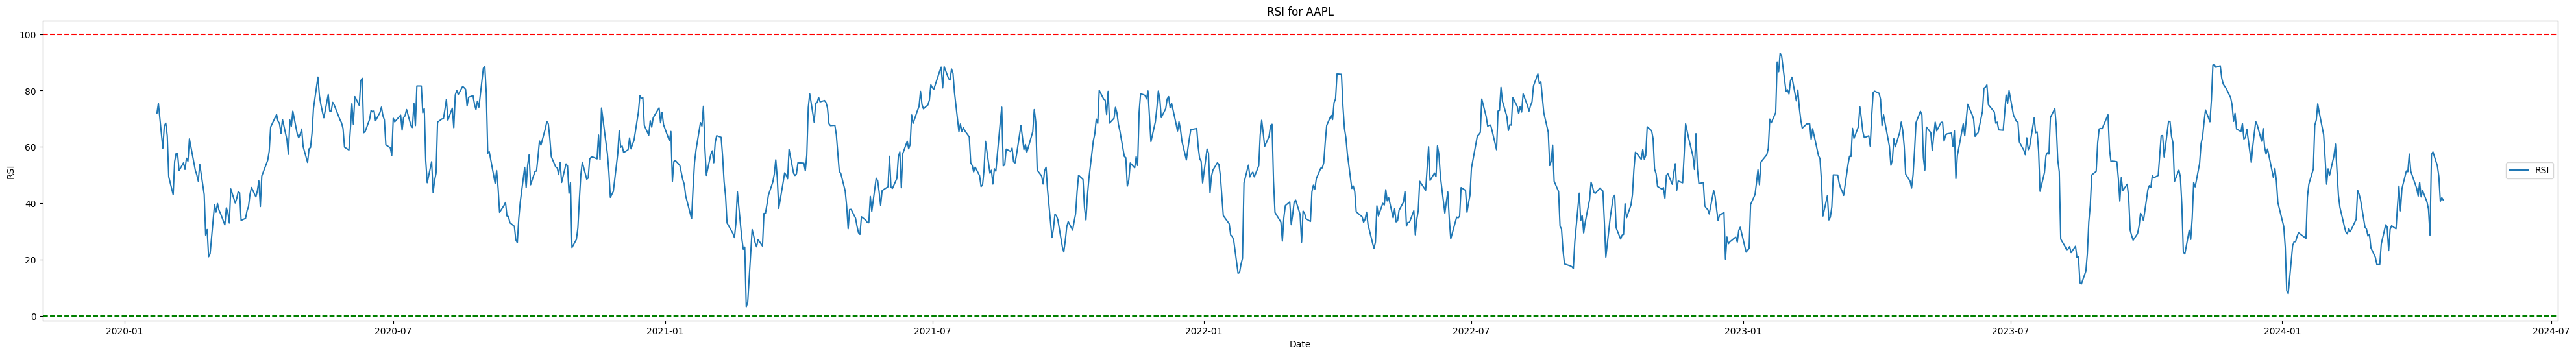

Date
2020-01-23    71.902779
2020-01-24    75.401678
2020-01-27    59.513528
2020-01-28    67.412567
2020-01-29    68.465238
                ...    
2024-04-15    53.230333
2024-04-16    49.461661
2024-04-17    40.661275
2024-04-18    41.944842
2024-04-19    41.065720
Name: RSI, Length: 1068, dtype: float64

In [30]:
def RSI(dataset, column, tickers, n=14):
    for ticker in tickers:
        if ticker in dataset:
            delta = dataset[ticker][column].diff().dropna()
            up, down = delta.copy(), delta.copy()
            up[up < 0] = 0
            down[down > 0] = 0

            
            roll_up = up.rolling(window=n).mean()
            roll_down = down.abs().rolling(window=n).mean()

            
            RS = roll_up / roll_down
            RSI = 100 - (100 / (1.0 + RS))

            dataset[ticker]['RSI'] = RSI
            plt.figure(figsize=(50,6))
            plt.plot(dataset[ticker]['RSI'], label='RSI')
            plt.title(f'RSI for {ticker}')
            plt.axhline(100, linestyle='--', color='red')
            plt.axhline(0, linestyle='--', color='green')
            plt.xlabel('Date')
            plt.ylabel('RSI')
            plt.legend()
            plt.show()

            

    return dataset[ticker]["RSI"].dropna()  

RSI(fortune500_dataset, "Adj Close", ["AAPL"])

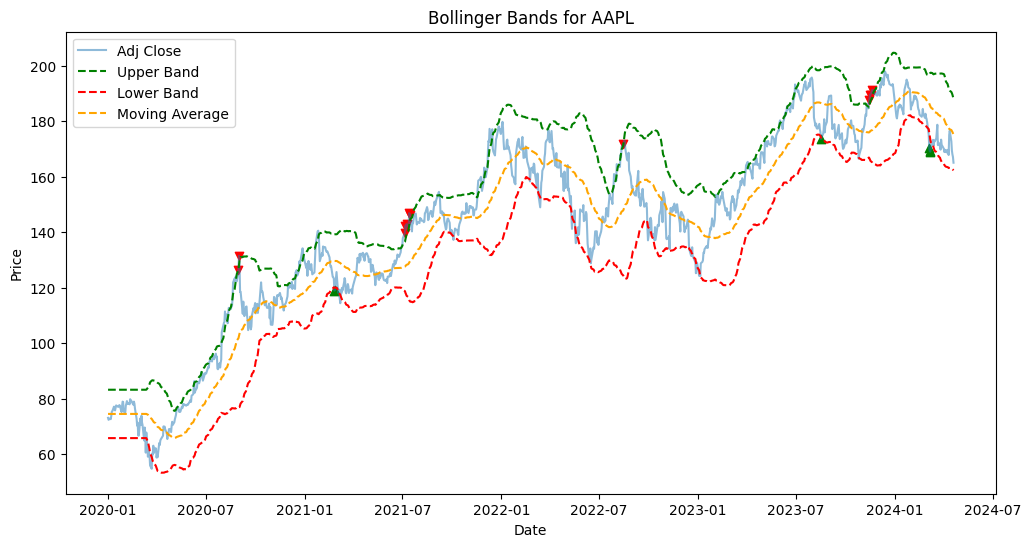

In [31]:
def BBRSI(dataset, tickers, column):
    for ticker in tickers:
        if ticker in dataset:
            if "Buy Signal" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Buy Signal"])
            if "Sell Signal" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Sell Signal"])
            dataset[ticker]["Buy Signal"] = (dataset[ticker]["Adj Close"] < dataset[ticker]["Lower Band"]) & (dataset[ticker]["RSI"] < 20)
            dataset[ticker]["Sell Signal"] = (dataset[ticker]["Adj Close"] > dataset[ticker]["Upper Band"]) & (dataset[ticker]["RSI"] > 85)
            plt.figure(figsize=(12,6))
            plt.plot(dataset[ticker]['Adj Close'], label='Adj Close', alpha=0.5)
            plt.plot(dataset[ticker]['Upper Band'], label='Upper Band', color='green', linestyle='--')
            plt.plot(dataset[ticker]['Lower Band'], label='Lower Band', color='red', linestyle='--')
            plt.plot(dataset[ticker]['MA'], label='Moving Average', color='orange', linestyle='--')
            plt.scatter(dataset[ticker][dataset[ticker]["Buy Signal"]].index, dataset[ticker][dataset[ticker]["Buy Signal"]]["Adj Close"], color='green', marker='^', alpha=1)
            plt.scatter(dataset[ticker][dataset[ticker]["Sell Signal"]].index, dataset[ticker][dataset[ticker]["Sell Signal"]]["Adj Close"], color='red', marker='v', alpha=1)
            plt.title(f'Bollinger Bands for {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.show()
            

    

BBRSI(fortune500_dataset, ["AAPL"], "Adj Close")    

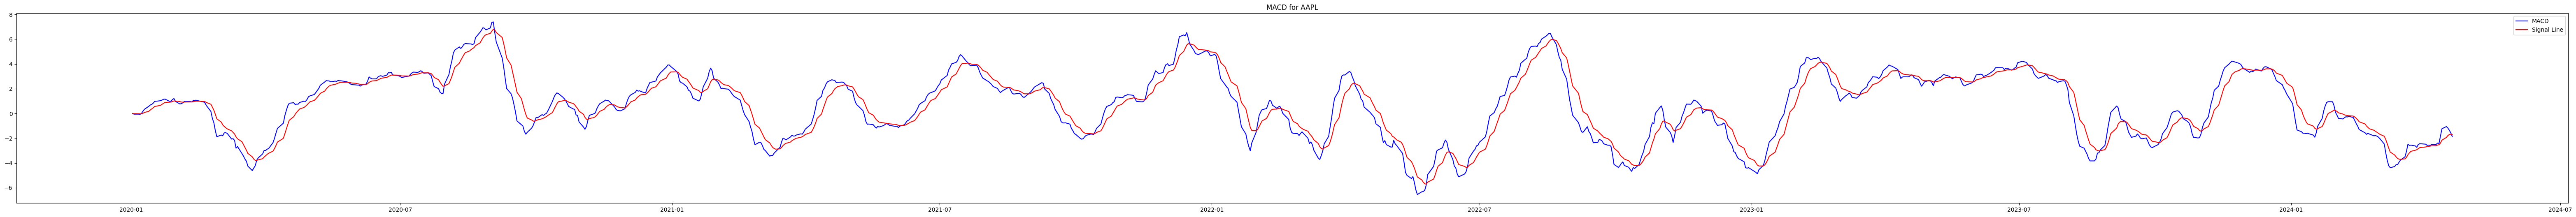

In [32]:
def trendStalker(dataset, tickers, column):
    for ticker in tickers:
        if ticker in dataset:
            if "Buy Signal" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Buy Signal"])
            if "Sell Signal" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Sell Signal"])
            dataset[ticker]["MACD"] = dataset[ticker][column].ewm(span=12, adjust=False).mean() - dataset[ticker][column].ewm(span=26, adjust=False).mean()
            dataset[ticker]["Signal Line"] = dataset[ticker]["MACD"].ewm(span=9, adjust=False).mean()
            dataset[ticker]["Buy Signal"] = dataset[ticker]["MACD"] > dataset[ticker]["Signal Line"]
            dataset[ticker]["Sell Signal"] = dataset[ticker]["MACD"] < dataset[ticker]["Signal Line"]  
            plt.figure(figsize=(80,6))
            plt.plot(dataset[ticker]["MACD"], label='MACD', color='blue')
            plt.plot(dataset[ticker]["Signal Line"], label='Signal Line', color='red')
            plt.title(f'MACD for {ticker}')
            plt.legend()
            plt.show()


trendStalker(fortune500_dataset, ["AAPL"], "Adj Close")

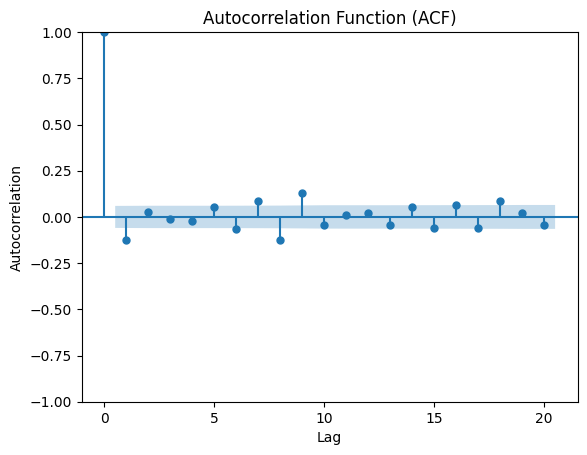

Mean Squared Error for AAPL: 7.472045449559737
R^2 for AAPL: 0.9798366253257705


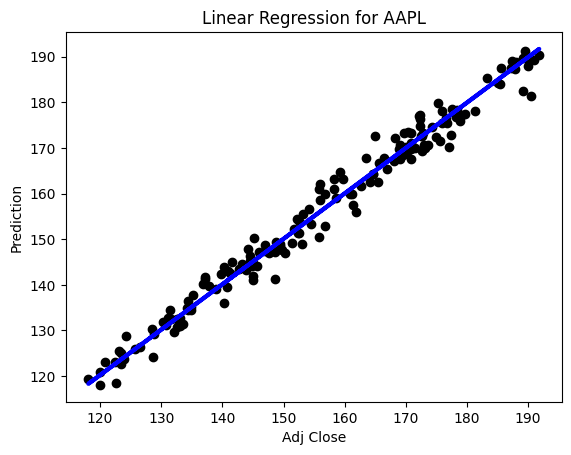

In [33]:
autocorrelation = fortune500_dataset["AAPL"]["lnret"].autocorr()

# Plot autocorrelation function (ACF)
plot_acf(fortune500_dataset["AAPL"]["lnret"], lags=20)  # Adjust 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

def linearreg(dataset, tickers, column, n):
    for ticker in tickers:
        if ticker in dataset:
            if "Prediction" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Prediction"])
            dataset[ticker]["Prediction"] = dataset[ticker][column].shift(-n)
            dataset[ticker] = dataset[ticker].dropna()
            X = dataset[ticker][column].values.reshape(-1,1)
            y = dataset[ticker]["Prediction"].values.reshape(-1,1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            model = LinearRegression()
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            print(f"Mean Squared Error for {ticker}: {mse}")
            print(f"R^2 for {ticker}: {r2}")
            plt.scatter(X_test, y_test, color='black')
            plt.plot(X_test, predictions, color='blue', linewidth=3)
            plt.title(f'Linear Regression for {ticker}')
            plt.xlabel(column)
            plt.ylabel('Prediction')
            plt.show()


linearreg(fortune500_dataset, ["AAPL"], "Adj Close", 1) 

            
         

In [34]:
def NN(dataset, tickers, column, n):
    for ticker in tickers:
        if ticker in dataset:
            if "Prediction" in dataset[ticker]:
                dataset[ticker]= dataset[ticker].drop(columns=["Prediction"])   
            dataset[ticker]["Prediction"] = dataset[ticker][column].shift(-n)   
            dataset[ticker].dropna(subset=["Prediction"], inplace=True)  
            X = dataset[ticker][column].values.reshape(-1,1)
            y = dataset[ticker]["Prediction"].values.reshape(-1,1)  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            mse = mean_squared_error(y_test, y_pred)
            print("Mean Squared Error:", mse)


NN(fortune500_dataset, ["AAPL"], "Adj Close", 1)    




C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 6.132603538561503


In [35]:
def backtestsimple(dataset, tickers):
    
    portfolio = {}
    for ticker in tickers:
        portfolio[ticker] = {'position': 'out', 'cash': 1000000, 'shares': 0}
    
    
    for ticker in tickers:
        if ticker in dataset:
            for i in range(len(dataset[ticker])):
                if dataset[ticker]["Buy Signal"].iloc[i]:
                    if portfolio[ticker]['position'] == 'out':
                        portfolio[ticker]['shares'] = portfolio[ticker]['cash'] / dataset[ticker]['Adj Close'].iloc[i]
                        portfolio[ticker]['cash'] = 0
                        portfolio[ticker]['position'] = 'long'
                elif dataset[ticker]["Sell Signal"].iloc[i]:
                    if portfolio[ticker]['position'] == 'long':
                        portfolio[ticker]['cash'] = portfolio[ticker]['shares'] * dataset[ticker]['Adj Close'].iloc[i]
                        portfolio[ticker]['shares'] = 0
                        portfolio[ticker]['position'] = 'out'
    
    total_value = sum(portfolio[ticker]['cash'] + portfolio[ticker]['shares'] * dataset[ticker]['Adj Close'].iloc[-1] for ticker in tickers)
    return total_value

tickers = ['AAPL']  
total_portfolio_value = backtestsimple(fortune500_dataset, tickers)
total_portfolio_return = round(((total_portfolio_value - 1000000) / 1000000)*100, 3)
annualized_portfolio_return = round(((1 + total_portfolio_return/100)**(252/len(fortune500_dataset[tickers[0]])) - 1)*100, 3)   
print("Total portfolio value:", total_portfolio_value, "\nTotal portfolio return:", total_portfolio_return , "%", "\nAnnualized portfolio return:", annualized_portfolio_return, "%")

Total portfolio value: 1502782.666309546 
Total portfolio return: 50.278 % 
Annualized portfolio return: 13.181 %


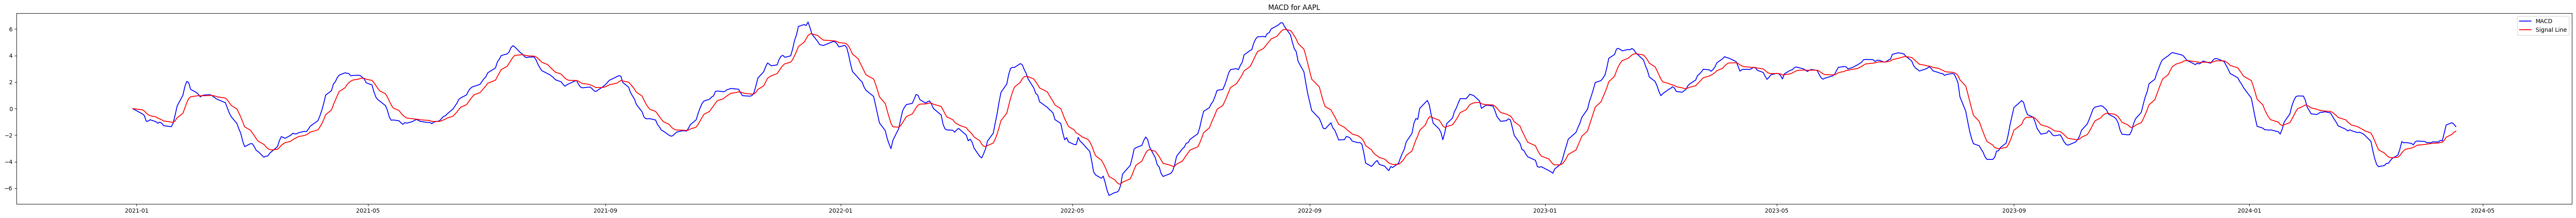

'Final Value:1542870.5113582269, Total Return:54.287%, Annualized Return:14.09%'

In [36]:
'''
from da import DataAnalysis

analysis = DataAnalysis(fortune500_dataset)   
analysis.getADF(["AAPL"], "Adj Close")
analysis.plotDistr(['AAPL'], 'lnret')
analysis.getQQPlotted(['AAPL'], 'lnret')
analysis.getSWTested(["AAPL"], 'lnret')
analysis.getKSTested(["AAPL"], ["lnret"])   


from TS1 import TS

ts = TS(fortune500_dataset) 
ts.buyandhold("lnret", ["AAPL"], 1000000)
ts.trendStalker(["AAPL"], "Adj Close")
ts.backtestsimple(["AAPL"]) 
'''